In [1]:
import simi

import pandas as pd
from sentence_transformers import evaluation, losses, models, InputExample, SentenceTransformer
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, BertForMaskedLM, AutoModelForMaskedLM, AutoModel

from tqdm.auto import tqdm
tqdm.pandas()

RANDOM_STATE = 1

#set_seed(RANDOM_STATE)
#enable_full_determinism(RANDOM_STATE)


# SentenceTransformers cosine-similarity scoring for (m)class
def st_similarity_scoring(df, model, append=False, name="cos-sim"):
    scores = df.progress_apply(lambda r: simi.pairwise_cosine_similarity(simi.model_embeddings(model, [r["title_a"], r["title_b"]]))[0][0], axis=1)
    scores = pd.Series(scores, index=df.index, name=name)
    if append:
        return df.merge(scores.to_frame(), left_index=True, right_index=True)
    return scores

2024-01-07 18:07:02.104077: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load and select test data

In [2]:
df = pd.read_csv("class-zbmath-dataset.csv", index_col=0)
df.sample(5)

,title_a,MSC_a,MSC2_a,title_b,MSC_b,MSC2_b,label
328099,Non-smooth solutions of the elastic wave equat...,35Q72,"('35P25', '74J10')",On the well posedness of the Cauchy problem fo...,35L20,"('35B35',)",0
389672,"Symplectic geometry of \(SU_{q,\hslash \to 0}(...",17B81,"('81R50', '53C80', '17B37')",Two non-nilpotent linear transformations that ...,17B37,"('16T20', '05E30', '33D45', '33D80')",0
437632,Diverse beliefs,91B51,"('91B50', '91B69', '91B70')",Existence of financial equilibria with restric...,91B51,"('91B70',)",1
30966,Projective modules for Frobenius kernels and f...,20G05,"('20G40', '17B50', '17B55')",Quasi-permutation representations of \(\text{S...,20G05,"('20C15', '20G40')",1
257192,A concept of similarity for intuitionistic fuz...,03E72,"('68T35', '68T37')",Efficiently simulating higher-order arithmetic...,03B35,"('03B15', '03F20', '03F35', '68Q42')",0


In [3]:
X_treval, X_test = train_test_split(df, train_size=0.9, random_state=RANDOM_STATE)
X_train, X_eval = train_test_split(X_treval, train_size=0.888889, random_state=RANDOM_STATE)
print("train:", len(X_train), "eval:", len(X_eval), "test:", len(X_test))

train: 351472 eval: 43935 test: 43935


## Model definitions

In [4]:
# combine models into dict
eval_models = {
    "BERT+CLS+ANCH-ARX": SentenceTransformer('./bert+cls+retrain_anchor_arxiv'),
    "BERT+MP+ANCH-ARX": SentenceTransformer('./bert+mean-pooling+retrain_anchor_arxiv'),
    "BERT+CLS+CLASS-ARX": SentenceTransformer('./bert+cls+retrain_class_arxiv'),
    "BERT+MP+CLASS-ARX": SentenceTransformer('./bert+mean-pooling+retrain_class_arxiv'),
    "BERT+CLS+CLASS-ZBM": SentenceTransformer('./bert+cls+retrain_class_zbmath'),
    "BERT+MP+CLASS-ZBM": SentenceTransformer('./bert+mean-pooling+retrain_class_zbmath'),
    
    "SBERT+MP+ANCH-ARX": SentenceTransformer('./sbert+retrain_anchor_arxiv'),
    "SBERT+MP+CLASS-ARX": SentenceTransformer('./sbert+retrain_class_arxiv'),
    "SBERT+MP+CLASS-ZBM": SentenceTransformer('./sbert+retrain_class_zbmath'),
    
    "MathBERT+CLS+ANCH-ARX": SentenceTransformer('./mathbert+cls+retrain_anchor_arxiv'),
    "MathBERT+MP+ANCH-ARX": SentenceTransformer('./mathbert+mean-pooling+retrain_anchor_arxiv'),
    "MathBERT+CLS+CLASS-ARX": SentenceTransformer('./mathbert+cls+retrain_class_arxiv'),
    "MathBERT+MP+CLASS-ARX": SentenceTransformer('./mathbert+mean-pooling+retrain_class_arxiv'),
    "MathBERT+CLS+CLASS-ZBM": SentenceTransformer('./mathbert+cls+retrain_class_zbmath'),
    "MathBERT+MP+CLASS-ZBM": SentenceTransformer('./mathbert+mean-pooling+retrain_class_zbmath'),
    
    "SPECTER2+CLS+ANCH-ARX": SentenceTransformer('./specter2+cls+retrain_anchor_arxiv'),
    "SPECTER2+MP+ANCH-ARX": SentenceTransformer('./specter2+mp+retrain_anchor_arxiv'),
    "SPECTER2+CLS+CLASS-ARX": SentenceTransformer('./specter2+cls+retrain_class_arxiv'),
    "SPECTER2+MP+CLASS-ARX": SentenceTransformer('./specter2+mp+retrain_class_arxiv'),
    "SPECTER2+CLS+CLASS-ZBM": SentenceTransformer('./specter2+cls+retrain_class_zbmath'),
    "SPECTER2+MP+CLASS-ZBM": SentenceTransformer('./specter2+mp+retrain_class_zbmath'),
    
    "SGPT+ANCH-ARX": SentenceTransformer('./gpt+retrain_anchor_arxiv'),
    "SGPT+CLASS-ARX": SentenceTransformer('./gpt+retrain_class_arxiv'),
    "SGPT+CLASS-ZBM": SentenceTransformer('./gpt+retrain_class_zbmath'),
    
    "BERT+MLM+CLS+ANCH-ARX": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+cls+retrain_anchor_arxiv'),
    "BERT+MLM+MP+ANCH-ARX": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_anchor_arxiv'),
    "BERT+MLM+CLS+CLASS-ARX": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+cls+retrain_class_arxiv'),
    "BERT+MLM+MP+CLASS-ARX": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv'),
    "BERT+MLM+CLS+CLASS-ZBM": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+cls+retrain_class_zbmath'),
    "BERT+MLM+MP+CLASS-ZBM": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_zbmath'),
    
    "BERT+CLS+TSDAE+ANCH-ARX": SentenceTransformer('./bert+cls+re-train_tsdae_abstracts_arxiv+retrain_anchor_arxiv'),
    "BERT+MP+TSDAE+ANCH-ARX": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv+retrain_anchor_arxiv'),
    "BERT+CLS+TSDAE+CLASS-ARX": SentenceTransformer('./bert+cls+re-train_tsdae_abstracts_arxiv+retrain_class_arxiv'),
    "BERT+MP+TSDAE+CLASS-ARX": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv+retrain_class_arxiv'),
    "BERT+CLS+TSDAE+CLASS-ZBM": SentenceTransformer('./bert+cls+re-train_tsdae_abstracts_arxiv+retrain_class_zbmath'),
    "BERT+MP+TSDAE+CLASS-ZBM": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv+retrain_class_zbmath'),
}

## Spearman-Pearson-rank-coefficient for test data

In [5]:
eval_examples = X_test.reset_index(drop=True).apply(lambda r: InputExample(texts=[r["title_a"], r["title_b"]], label=r["label"]), axis=1)
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(eval_examples, batch_size=64, show_progress_bar=True)

In [6]:
%%time
spear_rancs = {}

with tqdm(total=len(eval_models)) as pb:
    for n,m in eval_models.items():
        pb.set_postfix_str("Current model: {}".format(n))
        spear_rancs[n] = [m.evaluate(evaluator)]
        pb.update()
        
spear_ranc_df = pd.DataFrame(spear_rancs)

  0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

Batches:   0%|          | 0/687 [00:00<?, ?it/s]

CPU times: user 3h 7min 16s, sys: 14min 37s, total: 3h 21min 53s
Wall time: 45min 34s


In [7]:
pd.set_option('display.max_columns', 40)

In [8]:
spear_ranc_df

,BERT+CLS+ANCH-ARX,BERT+MP+ANCH-ARX,BERT+CLS+CLASS-ARX,BERT+MP+CLASS-ARX,BERT+CLS+CLASS-ZBM,BERT+MP+CLASS-ZBM,SBERT+MP+ANCH-ARX,SBERT+MP+CLASS-ARX,SBERT+MP+CLASS-ZBM,MathBERT+CLS+ANCH-ARX,MathBERT+MP+ANCH-ARX,MathBERT+CLS+CLASS-ARX,MathBERT+MP+CLASS-ARX,MathBERT+CLS+CLASS-ZBM,MathBERT+MP+CLASS-ZBM,SPECTER2+CLS+ANCH-ARX,SPECTER2+MP+ANCH-ARX,SPECTER2+CLS+CLASS-ARX,SPECTER2+MP+CLASS-ARX,SPECTER2+CLS+CLASS-ZBM,SPECTER2+MP+CLASS-ZBM,SGPT+ANCH-ARX,SGPT+CLASS-ARX,SGPT+CLASS-ZBM,BERT+MLM+CLS+ANCH-ARX,BERT+MLM+MP+ANCH-ARX,BERT+MLM+CLS+CLASS-ARX,BERT+MLM+MP+CLASS-ARX,BERT+MLM+CLS+CLASS-ZBM,BERT+MLM+MP+CLASS-ZBM,BERT+CLS+TSDAE+ANCH-ARX,BERT+MP+TSDAE+ANCH-ARX,BERT+CLS+TSDAE+CLASS-ARX,BERT+MP+TSDAE+CLASS-ARX,BERT+CLS+TSDAE+CLASS-ZBM,BERT+MP+TSDAE+CLASS-ZBM
0,0.289556,0.288364,0.172924,0.192109,0.57209,0.572631,0.222688,0.218569,0.60795,0.343677,0.349326,0.181726,0.188952,0.566402,0.576517,0.383504,0.392185,0.175164,0.180666,0.58601,0.592743,0.357482,0.24131,0.544242,0.41767,0.417959,0.202715,0.211958,0.594463,0.60916,0.349164,0.358593,0.165758,0.180612,0.578005,0.581848


In [9]:
X_test_score = X_test.copy()

In [10]:
%%time
with tqdm(total=len(eval_models)) as pb:
    for n,m in eval_models.items():
        pb.set_postfix_str("Current model: {}".format(n))
        X_test_score["cos-sim ({})".format(n)] = st_similarity_scoring(X_test, m)
        pb.update()

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

  0%|          | 0/43935 [00:00<?, ?it/s]

CPU times: user 7h 24min 25s, sys: 9min 30s, total: 7h 33min 56s
Wall time: 3h 40min 42s


## Results for test data

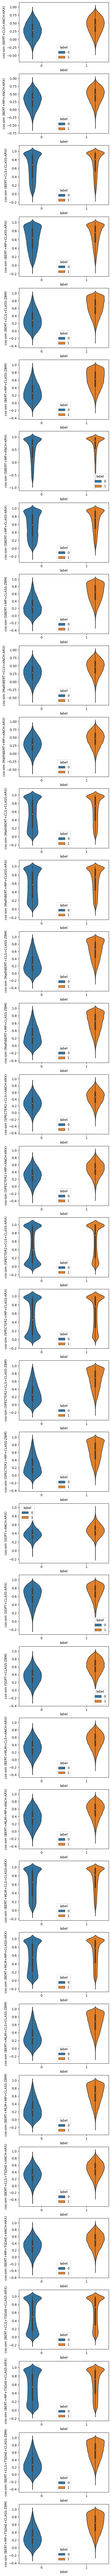

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
if len(eval_models) > 1:
    f, axs = plt.subplots(len(eval_models), 1, figsize=(5, 4*len(eval_models)))
    for i,n in enumerate(eval_models.keys()):
        sns.violinplot(X_test_score, x="label", y="cos-sim ({})".format(n), hue="label", ax=axs[i], scale="count", scale_hue=True)
else:
    for n in eval_models.keys():
        sns.violinplot(X_test_score, x="label", y="cos-sim ({})".format(n), hue="label", scale="count", scale_hue=True)

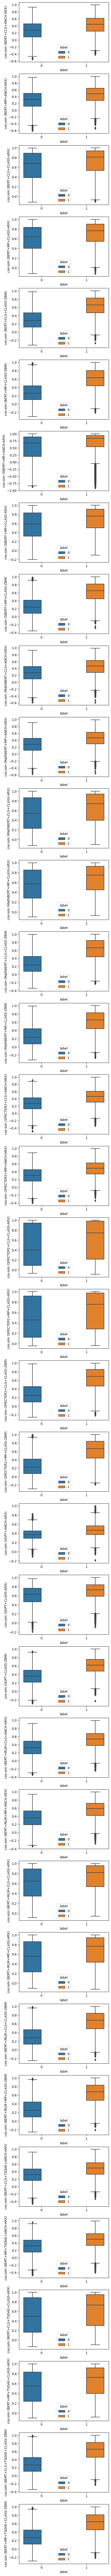

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axs = plt.subplots(len(eval_models), 1, figsize=(5, 4*len(eval_models)))
for i,n in enumerate(eval_models.keys()):
    sns.boxplot(X_test_score, x="label", y="cos-sim ({})".format(n), hue="label", ax=axs[i])

In [13]:
X_test_score[X_test_score["label"] == 1].describe()

,label,cos-sim (BERT+CLS+ANCH-ARX),cos-sim (BERT+MP+ANCH-ARX),cos-sim (BERT+CLS+CLASS-ARX),cos-sim (BERT+MP+CLASS-ARX),cos-sim (BERT+CLS+CLASS-ZBM),cos-sim (BERT+MP+CLASS-ZBM),cos-sim (SBERT+MP+ANCH-ARX),cos-sim (SBERT+MP+CLASS-ARX),cos-sim (SBERT+MP+CLASS-ZBM),cos-sim (MathBERT+CLS+ANCH-ARX),cos-sim (MathBERT+MP+ANCH-ARX),cos-sim (MathBERT+CLS+CLASS-ARX),cos-sim (MathBERT+MP+CLASS-ARX),cos-sim (MathBERT+CLS+CLASS-ZBM),cos-sim (MathBERT+MP+CLASS-ZBM),cos-sim (SPECTER2+CLS+ANCH-ARX),cos-sim (SPECTER2+MP+ANCH-ARX),cos-sim (SPECTER2+CLS+CLASS-ARX),cos-sim (SPECTER2+MP+CLASS-ARX),cos-sim (SPECTER2+CLS+CLASS-ZBM),cos-sim (SPECTER2+MP+CLASS-ZBM),cos-sim (SGPT+ANCH-ARX),cos-sim (SGPT+CLASS-ARX),cos-sim (SGPT+CLASS-ZBM),cos-sim (BERT+MLM+CLS+ANCH-ARX),cos-sim (BERT+MLM+MP+ANCH-ARX),cos-sim (BERT+MLM+CLS+CLASS-ARX),cos-sim (BERT+MLM+MP+CLASS-ARX),cos-sim (BERT+MLM+CLS+CLASS-ZBM),cos-sim (BERT+MLM+MP+CLASS-ZBM),cos-sim (BERT+CLS+TSDAE+ANCH-ARX),cos-sim (BERT+MP+TSDAE+ANCH-ARX),cos-sim (BERT+CLS+TSDAE+CLASS-ARX),cos-sim (BERT+MP+TSDAE+CLASS-ARX),cos-sim (BERT+CLS+TSDAE+CLASS-ZBM),cos-sim (BERT+MP+TSDAE+CLASS-ZBM)
count,21860.0,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000
mean,1.0,0.424462,0.455494,0.715349,0.700279,0.631624,0.606138,0.676370,0.688573,0.620140,0.447336,0.449645,0.654688,0.669801,0.624231,0.617105,0.452277,0.477169,0.613176,0.630077,0.645354,0.623255,0.468311,0.696587,0.607590,0.517761,0.555622,0.719975,0.670901,0.650226,0.641958,0.475999,0.481556,0.625398,0.642550,0.625228,0.619811
std,0.0,0.250481,0.250208,0.266603,0.239902,0.234720,0.236099,0.383655,0.263889,0.237711,0.241362,0.235789,0.307699,0.283141,0.256315,0.249830,0.211232,0.203899,0.374904,0.354289,0.246375,0.251713,0.137594,0.183433,0.191772,0.207469,0.212447,0.270514,0.300630,0.230830,0.233250,0.217080,0.222009,0.341227,0.303352,0.239319,0.232036
min,1.0,-0.410140,-0.535370,-0.105256,-0.118549,-0.264545,-0.202123,-0.913697,-0.101684,-0.282786,-0.586985,-0.549449,-0.104502,-0.072045,-0.230072,-0.264578,-0.338985,-0.340848,-0.088062,-0.040375,-0.212822,-0.187499,-0.185385,-0.086816,-0.226307,-0.240888,-0.267405,-0.058931,-0.123438,-0.226631,-0.202500,-0.328294,-0.394601,-0.100885,-0.079079,-0.223784,-0.208621
25%,1.0,0.248554,0.288551,0.536384,0.542690,0.467572,0.437492,0.545578,0.502962,0.450185,0.285927,0.293089,0.398528,0.448850,0.438920,0.440707,0.311007,0.343089,0.216267,0.279731,0.467025,0.439034,0.372323,0.587356,0.477271,0.379449,0.419349,0.535015,0.435285,0.484874,0.480871,0.326985,0.331009,0.301947,0.396224,0.454671,0.452552
50%,1.0,0.443372,0.483382,0.809691,0.763093,0.660613,0.629491,0.843729,0.764518,0.648846,0.471993,0.472051,0.740590,0.748197,0.663457,0.655721,0.467769,0.491186,0.745436,0.754425,0.689693,0.662074,0.467543,0.731604,0.620880,0.537904,0.585929,0.815516,0.767867,0.685851,0.678568,0.493400,0.500810,0.734488,0.724403,0.656215,0.646014
75%,1.0,0.617287,0.647769,0.941597,0.902767,0.826037,0.801778,0.946722,0.916141,0.818695,0.631865,0.628586,0.942532,0.926044,0.844307,0.826807,0.608811,0.627687,0.982551,0.972117,0.855190,0.838572,0.563896,0.840201,0.755498,0.674682,0.718106,0.954346,0.942875,0.844612,0.836149,0.639660,0.649858,0.951856,0.918309,0.824301,0.813449
max,1.0,0.992375,0.995349,0.999697,0.999371,0.999523,0.999248,0.999946,0.999947,0.999711,0.985128,0.990611,0.999908,0.999955,0.999557,0.999372,0.992595,0.991790,0.999959,0.999896,0.999721,0.999480,0.993297,0.999447,0.999586,0.993684,0.996439,0.999843,0.999709,0.999684,0.999477,0.994541,0.994557,0.999680,0.999366,0.999409,0.999342


In [14]:
X_test_score[X_test_score["label"] == 0].describe()

,label,cos-sim (BERT+CLS+ANCH-ARX),cos-sim (BERT+MP+ANCH-ARX),cos-sim (BERT+CLS+CLASS-ARX),cos-sim (BERT+MP+CLASS-ARX),cos-sim (BERT+CLS+CLASS-ZBM),cos-sim (BERT+MP+CLASS-ZBM),cos-sim (SBERT+MP+ANCH-ARX),cos-sim (SBERT+MP+CLASS-ARX),cos-sim (SBERT+MP+CLASS-ZBM),cos-sim (MathBERT+CLS+ANCH-ARX),cos-sim (MathBERT+MP+ANCH-ARX),cos-sim (MathBERT+CLS+CLASS-ARX),cos-sim (MathBERT+MP+CLASS-ARX),cos-sim (MathBERT+CLS+CLASS-ZBM),cos-sim (MathBERT+MP+CLASS-ZBM),cos-sim (SPECTER2+CLS+ANCH-ARX),cos-sim (SPECTER2+MP+ANCH-ARX),cos-sim (SPECTER2+CLS+CLASS-ARX),cos-sim (SPECTER2+MP+CLASS-ARX),cos-sim (SPECTER2+CLS+CLASS-ZBM),cos-sim (SPECTER2+MP+CLASS-ZBM),cos-sim (SGPT+ANCH-ARX),cos-sim (SGPT+CLASS-ARX),cos-sim (SGPT+CLASS-ZBM),cos-sim (BERT+MLM+CLS+ANCH-ARX),cos-sim (BERT+MLM+MP+ANCH-ARX),cos-sim (BERT+MLM+CLS+CLASS-ARX),cos-sim (BERT+MLM+MP+CLASS-ARX),cos-sim (BERT+MLM+CLS+CLASS-ZBM),cos-sim (BERT+MLM+MP+CLASS-ZBM),cos-sim (BERT+CLS+TSDAE+ANCH-ARX),cos-sim (BERT+MP+TSDAE+ANCH-ARX),cos-sim (BERT+CLS+TSDAE+CLASS-ARX),cos-sim (BERT+MP+TSDAE+CLASS-ARX),cos-sim (BERT+CLS+TSDAE+CLASS-ZBM),cos-sim (BERT+MP+TSDAE+CLASS-ZBM)
count,22075.0,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000,22075.000000
mean,0.0,0.272467,0.302625,0.623005,0.603587,0.303259,0.281535,0.497955,0.564284,0.263193,0.270073,0.276261,0.536786,0.556436,0.272976,0.265729,0.275858,0.302450,0.484204,0.498959,0.289435,0.261805,0.373070,0.604341,0.355956,0.326079,0.357673,0.603935,0.537749,0.308112,0.282502,0.313021,0.311818,0.510976,0.530697,0.287467,0.291645
std,0.0,0.252597,0.262822,0.290887,0.264544,0.238604,0.231199,0.470271,0.292291,0.231769,0.249195,0.240046,0.330852,0.306023,0.255989,0.249695,0.215245,0.209675,0.392532,0.374778,0.246964,0.241829,0.118746,0.206115,0.200581,0.214602,0.229472,0.302379,0.327518,0.234002,0.236746,0.220130,0.224788,0.358461,0.319993,0.239720,0.229086
min,0.0,-0.543000,-0.601465,-0.115978,-0.121460,-0.313756,-0.297115,-0.866049,-0.197497,-0.358007,-0.582004,-0.571730,-0.121870,-0.099646,-0.344778,-0.314569,-0.492461,-0.400099,-0.066904,-0.042461,-0.258721,-0.289074,-0.103559,-0.192761,-0.280671,-0.342826,-0.336592,-0.088476,-0.104824,-0.247081,-0.253759,-0.455801,-0.465948,-0.137377,-0.099777,-0.343326,-0.284500
25%,0.0,0.087158,0.119048,0.387573,0.400892,0.121219,0.105977,0.196811,0.318047,0.086413,0.092398,0.106392,0.231569,0.282420,0.073965,0.070211,0.121841,0.155706,0.089670,0.120579,0.095645,0.073009,0.293265,0.466102,0.214023,0.172270,0.189806,0.344231,0.233712,0.129456,0.098084,0.159620,0.155310,0.161090,0.239752,0.105135,0.117596
50%,0.0,0.272505,0.319307,0.680456,0.641125,0.285744,0.262309,0.671455,0.589626,0.238294,0.277883,0.282405,0.541977,0.570668,0.239429,0.235548,0.277513,0.308076,0.398095,0.453479,0.254318,0.223551,0.372651,0.631680,0.358011,0.328142,0.363005,0.647004,0.554349,0.279598,0.253346,0.318756,0.321603,0.497328,0.546536,0.264880,0.270946
75%,0.0,0.460229,0.498492,0.889946,0.833556,0.470265,0.440324,0.891561,0.833480,0.416762,0.454796,0.453103,0.866543,0.850588,0.448960,0.439671,0.431218,0.452282,0.943808,0.917011,0.455816,0.418130,0.453596,0.766297,0.498312,0.484399,0.529576,0.891330,0.861143,0.464561,0.443059,0.472979,0.475137,0.890326,0.835584,0.451262,0.446842
max,0.0,0.932322,0.965393,0.998574,0.996343,0.980293,0.984320,0.997312,0.996955,0.981805,0.923677,0.907733,0.999224,0.998491,0.993305,0.991310,0.908645,0.888790,0.999515,0.999617,0.981064,0.994147,0.820437,0.975086,0.943193,0.918358,0.942699,0.999078,0.998041,0.988476,0.981634,0.922166,0.956657,0.999121,0.997977,0.992015,0.979608


In [15]:
X_test_score.sample(15, random_state=RANDOM_STATE)

,title_a,MSC_a,MSC2_a,title_b,MSC_b,MSC2_b,label,cos-sim (BERT+CLS+ANCH-ARX),cos-sim (BERT+MP+ANCH-ARX),cos-sim (BERT+CLS+CLASS-ARX),cos-sim (BERT+MP+CLASS-ARX),cos-sim (BERT+CLS+CLASS-ZBM),cos-sim (BERT+MP+CLASS-ZBM),cos-sim (SBERT+MP+ANCH-ARX),cos-sim (SBERT+MP+CLASS-ARX),cos-sim (SBERT+MP+CLASS-ZBM),cos-sim (MathBERT+CLS+ANCH-ARX),cos-sim (MathBERT+MP+ANCH-ARX),cos-sim (MathBERT+CLS+CLASS-ARX),cos-sim (MathBERT+MP+CLASS-ARX),...,cos-sim (SPECTER2+MP+ANCH-ARX),cos-sim (SPECTER2+CLS+CLASS-ARX),cos-sim (SPECTER2+MP+CLASS-ARX),cos-sim (SPECTER2+CLS+CLASS-ZBM),cos-sim (SPECTER2+MP+CLASS-ZBM),cos-sim (SGPT+ANCH-ARX),cos-sim (SGPT+CLASS-ARX),cos-sim (SGPT+CLASS-ZBM),cos-sim (BERT+MLM+CLS+ANCH-ARX),cos-sim (BERT+MLM+MP+ANCH-ARX),cos-sim (BERT+MLM+CLS+CLASS-ARX),cos-sim (BERT+MLM+MP+CLASS-ARX),cos-sim (BERT+MLM+CLS+CLASS-ZBM),cos-sim (BERT+MLM+MP+CLASS-ZBM),cos-sim (BERT+CLS+TSDAE+ANCH-ARX),cos-sim (BERT+MP+TSDAE+ANCH-ARX),cos-sim (BERT+CLS+TSDAE+CLASS-ARX),cos-sim (BERT+MP+TSDAE+CLASS-ARX),cos-sim (BERT+CLS+TSDAE+CLASS-ZBM),cos-sim (BERT+MP+TSDAE+CLASS-ZBM)
15960,Global exact quadratization of continuous-time...,93C10,"('93C15', '93A10', '34H05', '34H99', '34A34', ...",Mixed \(\mathcal{H}_2/\mathcal{H}_\infty\) con...,93E03,"('60J75', '93B36', '93C55', '93C05')",0,0.329861,0.769446,0.703047,0.854906,0.034876,0.124424,0.737738,0.909734,0.057709,0.577164,0.566835,0.534506,0.620304,...,0.461131,0.939377,0.917728,-0.021633,0.070588,0.363572,0.571317,0.416222,0.391930,0.783228,0.489195,0.551068,0.059668,0.151595,0.353587,0.508629,0.769912,0.827299,0.078115,0.024780
186573,Edge operators with conditions of Toeplitz type,58J40,"('35S15', '47G30', '35A17', '35J70', '58J32')",A Bismut type theorem for subelliptic heat sem...,58J20,"('35H20', '47D06')",0,0.033674,-0.115530,0.770909,0.717108,-0.028793,-0.034233,0.862910,0.813249,-0.007603,0.140097,0.385147,0.805682,0.443007,...,0.181981,0.182406,0.250784,0.283680,0.213685,0.332669,0.683608,0.161652,0.438641,0.489922,0.691970,0.735837,0.071096,0.113814,0.012043,0.023395,0.775495,0.344502,0.235845,0.018056
181977,1-cohomology and splitting of group extensions,20E22,"('20J99', '20E07')",On some products of nilpotent groups,20E22,"('20F16', '20F18', '20E07', '20F14', '20H25')",1,0.475293,0.734358,0.889310,0.927235,0.337959,0.298091,0.968944,0.751211,0.472616,0.447125,0.493337,0.978101,0.908274,...,0.497584,0.950083,0.872673,0.443820,0.188132,0.371440,0.765731,0.306472,0.633007,0.637835,0.919635,0.953277,0.603174,0.177687,0.598272,0.332681,0.981701,0.608892,0.330405,0.440679
299961,Reputation in the long-run with imperfect moni...,91A20,"('91A05',)",Parallel repetition via fortification: analyti...,91A20,"('81P40', '81P45', '91A05', '91A06', '91A12', ...",1,0.187246,0.569475,0.516956,0.386690,0.510755,0.489102,-0.070588,0.279987,0.616025,-0.132996,-0.063493,0.010493,0.056802,...,0.213916,0.016261,0.009117,0.240284,0.247166,0.345704,0.281690,0.379832,0.389345,0.302064,0.565469,0.268008,0.683497,0.795444,0.210200,0.260164,0.080020,0.219947,0.203649,0.294715
226982,Traces and quasi-traces on the Boutet de Monve...,58J42,"('35S15',)",The local and global parts of the basic zeta c...,58J42,"('35S15',)",1,0.143090,0.320764,0.131463,0.197189,0.065652,0.020792,0.707263,0.422831,0.347459,-0.042608,-0.104588,0.241964,0.191349,...,0.493562,0.422768,0.868663,0.420800,0.239283,0.362365,0.508852,0.189128,0.280440,0.364507,0.447198,0.374789,0.424792,0.485065,0.197735,0.341086,0.362291,0.831581,0.403171,0.180830
306772,A cyclic weight algorithm of decoding the \((4...,94B35,"('94B40',)",A result on the weight distributions of binary...,94B35,"('94B40',)",1,0.607192,0.611395,0.978699,0.953283,0.870213,0.872110,0.979820,0.917097,0.814251,0.722214,0.688531,0.918667,0.836470,...,0.508133,0.778082,0.930726,0.974929,0.954472,0.659663,0.582071,0.749723,0.641043,0.682685,0.814362,0.709239,0.914501,0.893838,0.643291,0.761212,0.989753,0.981701,0.870937,0.873755
205892,Properties of the Székely-Móri symmetry criter...,60E05